VAE: MNIST

In [ ]:
from torchvision.models import inception_v3
import numpy as np
from scipy import linalg
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
import torchvision.datasets as dst
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [ ]:



class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        inception = inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
      
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def calculate_activation_statistics(images,model,batch_size=128, dims=2048,cuda=False):
    model.eval()
    # activation = np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images

    pred = model(batch)[0]

    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)

    return mu, sigma

# Modified from: https://github.com/bioinf-jku/TTUR/blob/master/fid.py
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_fretchet(images_real,images_fake):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([block_idx])
    model=model.cuda()
    mu_1,std_1 = calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2 = calculate_activation_statistics(images_fake,model,cuda=True)

    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [ ]:
import torchvision.datasets as sets

class VAE(nn.Module):
    def __init__(self,img_dim=1024, z_dim = 100):
        super(VAE, self).__init__()
        self.img_dim = img_dim
        self.z_dim = z_dim


        self.encoder = nn.Sequential(
              nn.Linear(self.img_dim, 1024 ),
              nn.LeakyReLU(0.2, inplace=True),
              nn.Linear(1024, 512),
              nn.LeakyReLU(0.2, inplace=True),
              nn.Linear(512, 256),
              nn.LeakyReLU(0.2, inplace=True),
              nn.Linear(256, self.z_dim), 
              nn.Tanh()                
              )
        
        
        self.decoder = nn.Sequential(                
              nn.Linear(self.z_dim, 256),
              nn.ReLU(inplace=True),
              nn.Linear(256, 512),
              nn.ReLU(inplace=True),
              nn.Linear(512, 1024),
              nn.ReLU(inplace=True),
              nn.Linear(1024, self.img_dim),
              nn.Sigmoid()
              )

    def reparameterize(self, mu, logvar):
        eps = Variable(torch.randn(mu.size(0), mu.size(1))).to(device)
        z = mu + eps * torch.exp(logvar/2)            
        return z

    def forward(self, x):
        x = x.view(-1,self.img_dim)
        mu, logvar = self.encoder(x), self.encoder(x)  # batch_s, 8, 7, 7
        z = self.reparameterize(mu, logvar)      # batch_s, latent      
        fake =  self.decoder(z)   # batch_s, 8, 7, 7
        fake = fake.view(-1,1,32,32)
        
        return fake, mu, logvar


def loss_func(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x,reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE+KLD

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = loss_func(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return train_loss / len(train_loader.dataset)

def test():
    vae.eval()
    test_loss= 0
    FID = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)
            recon, mu, log_var = vae(data)
            test_loss += loss_func(recon, data, mu, log_var).item()
            
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)
            if batch_idx <=5:
                true = data.repeat(1,3, 1, 1)
                false_1,_,_ = vae.forward(data)
                false = false_1.repeat(1,3, 1, 1)
                FID += calculate_fretchet(true,false)

        
    test_loss /= len(test_loader.dataset)
    FID /= 5
    print('====> Val set loss: {:.4f}'.format(test_loss))
    print('====> FID: {:.4f}'.format(FID))

    return test_loss,FID

def run(Epoch):
    train_loss = []
    test_loss = []
    FID_list = []
    for epoch in range(Epoch):
        train_l = train(epoch)
        test_l,FID = test()
        train_loss.append(train_l)
        test_loss.append(test_l)
        FID_list.append(FID)
    return train_loss,test_loss,FID_list

In [237]:

BATCH_SIZE = 64
n = 2   # num_workers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    ###change mean
    # transforms.Normalize(mean = [ 0.5],
    #                       std  = [ 0.5]),
    ])

# transform=transforms.Compose([transforms.ToTensor()])
data_train = dst.MNIST('MNIST_data/', train=True, transform=transform, download=True)
data_test = dst.MNIST('MNIST_data/', train=False, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(
        data_train, [50000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = torch.utils.data.DataLoader(dataset=train_subset, num_workers=n,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, num_workers=n,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=data_test, num_workers=n,batch_size=BATCH_SIZE, shuffle=True,drop_last=True)

vae = VAE().to(device)
optimizer =  optim.Adam(vae.parameters(), lr=0.001)
train_loss,test_loss,FID_list = run(50)

LOSS

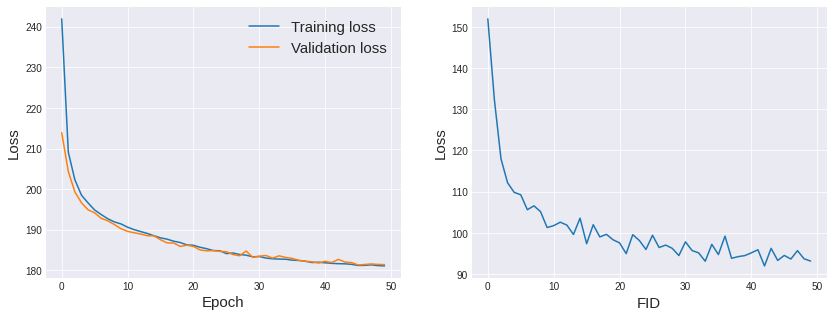

In [ ]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(train_loss,label='Training loss')
plt.plot(test_loss,label = 'Validation loss')
plt.xlabel('Epoch',size=15)
plt.ylabel('Loss',size=15)
plt.legend(fontsize=15)
plt.subplot(122)
plt.plot(FID_list)
plt.xlabel('FID',size=15)
plt.ylabel('Loss',size=15)
plt.savefig('./result/minist_vae',dpi=400,bbox_inches='tight')

GAN! MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Device configuration

class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=1024):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=1024):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))


def D_train(x,batch_size=100, z_dim=100, image_dim=1024,train=True):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, image_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    if train == True:
        D_loss.backward()
        D_optimizer.step()

    return  D_loss.data.item()

def G_train(x, batch_size=100, z_dim=100,train=True):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    if train == True:
        G_loss.backward()
        G_optimizer.step()

    return G_loss.data.item()

def test(batch_size=100,z_dim=100):
    G.eval()
    D.eval()
    test_D = 0
    test_G = 0
    FID = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            test_D += D_train(data,batch_size=batch_size,z_dim=z_dim,train=False)
            test_G += G_train(data,batch_size=batch_size,z_dim=z_dim,train=False)
            
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            if batch_idx <=5:
                true = data.repeat(1,3, 1, 1)
                z =  Variable(torch.randn(batch_size, z_dim).to(device))
                x_fake = G(z).view(batch_size,1,32,32)
                fake = x_fake.repeat(1,3, 1, 1)
                FID += calculate_fretchet(true,fake)

    test_G /= len(test_loader.dataset)
    test_D /= len(test_loader.dataset)
    FID /= 5
    print('====> Test set loss D, G : ', test_D,test_G)
    print('====> FID: ',FID)

    return test_G,test_D,FID

def run(Epoch=10,batch_size=100,z_dim=100):
    D_losses, G_losses, FID_class = [], [],[]
    testD_loss, testG_loss,FID_l = [],[],[]
    for epoch in range(Epoch): 
        train_D,train_G = 0,0          
        for batch_idx, (x, _) in enumerate(train_loader):
            train_D += D_train(x,batch_size=batch_size,z_dim=z_dim)
            train_G += G_train(x,batch_size=batch_size,z_dim=z_dim)
        
        test_G,test_D,FID = test()
        D_losses.append(train_D/len(train_loader.dataset))
        G_losses.append(train_G/len(train_loader.dataset))
        testG_loss.append(test_G)
        testD_loss.append(test_D)
        FID_l.append(FID)
        

        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f, FID:%.3f' % (
                (epoch+1), Epoch, train_D/len(train_loader.dataset), train_G/len(train_loader.dataset),FID))
    return D_losses,G_losses,testG_loss,testD_loss,FID_l





In [ ]:
G = Generator()
D = Discriminator()
print("Generator Parameters:",sum(p.numel() for p in G.parameters() if p.requires_grad))
print("Discriminator Parameters:",sum(p.numel() for p in D.parameters() if p.requires_grad))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator().to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss(reduction='sum') 
# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

# MNIST Dataset

# MNIST Dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
    ])

data_train = dst.MNIST('MNIST_data/', train=True, transform=transform, download=True)
data_test = dst.MNIST('MNIST_data/', train=False, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(
        data_train, [50000, 10000], generator=torch.Generator().manual_seed(1))

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_subset, num_workers=2,batch_size=100,shuffle=True,drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, num_workers=2,batch_size=100,shuffle=True,drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=100, shuffle=False,drop_last=True)

D_losses,G_losses,testG_loss,testD_loss,FID_l = run(Epoch=80)

====> Test set loss D, G :  1.1075576538085938 0.6176837539672851
====> FID:  436.2019731640956
[1/80]: loss_d: 1.009, loss_g: 2.748, FID:436.202
====> Test set loss D, G :  2.036198028564453 0.5881444774627685
====> FID:  473.0651007845762
[2/80]: loss_d: 0.945, loss_g: 2.903, FID:473.065
====> Test set loss D, G :  0.5832065525054931 2.0273391830444334
====> FID:  424.64333572604335
[3/80]: loss_d: 1.090, loss_g: 1.796, FID:424.643
====> Test set loss D, G :  1.0944364624023437 0.8494206733703613
====> FID:  411.53952821326476
[4/80]: loss_d: 1.145, loss_g: 1.613, FID:411.540
====> Test set loss D, G :  0.7143704841613769 1.7212922882080077
====> FID:  431.75420931276784
[5/80]: loss_d: 1.103, loss_g: 1.331, FID:431.754
====> Test set loss D, G :  0.7654515571594238 2.033835707092285
====> FID:  478.8007854329464
[6/80]: loss_d: 0.837, loss_g: 2.035, FID:478.801
====> Test set loss D, G :  0.8881450698852539 1.4242143005371093
====> FID:  313.9679711404805
[7/80]: loss_d: 0.586, loss

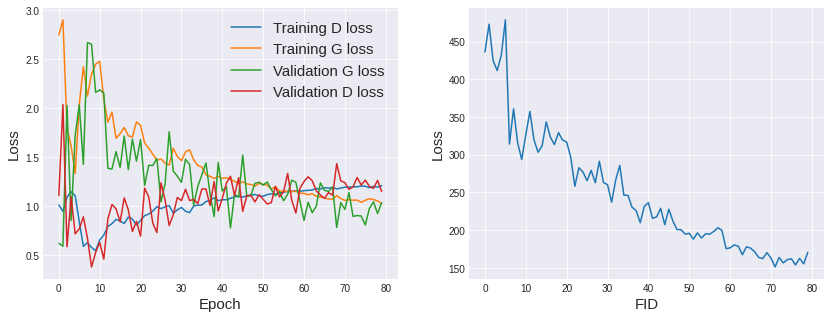

In [ ]:
# D_losses,G_losses,testG_loss,testD_loss,FID_l

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(D_losses,label='Training D loss')
plt.plot(G_losses,label = 'Training G loss')
plt.plot(testG_loss,label='Validation G loss')
plt.plot(testD_loss,label = 'Validation D loss')
plt.xlabel('Epoch',size=15)
plt.ylabel('Loss',size=15)
plt.legend(fontsize=15)
plt.subplot(122)
plt.plot(FID_l)
plt.xlabel('FID',size=15)
plt.ylabel('Loss',size=15)
plt.savefig('./result/minist_gan',dpi=400,bbox_inches='tight')

**Generating image**

VAE


In [ ]:
with torch.no_grad():
    z = torch.randn(16, 100).cuda()
    sample =  vae.decoder(z)   # batch_s, 8, 7, 7
    save_image(sample.view(16, 1, 32, 32), './result/VAE_sample_1' + '.png')

GAN

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(16, 100).to(device))
    generated = G(test_z)
    save_image(generated.view(generated.size(0), 1, 32, 32), './result/GAN_sample_1' + '.png')

Interpolation

In [ ]:
vae = torch.load('/content/drive/MyDrive/result/vae')
G = torch.load('/content/drive/MyDrive/result/G')

In [ ]:
z_1 = torch.randn(1, 100)
z_2 = torch.randn(1, 100)

In [ ]:
def interpolate_vae(autoencoder,z_1,z_2, n=10):
    z_1 = z_1.cuda()
    z_2 = z_2.cuda()
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    out3 = autoencoder.decoder(z)   # batch_s, 8, 7, 7
    interpolate_list =  out3.view(10, 1, 32, 32)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 32
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(32, 32)
    plt.imshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('./minist_vae_inte',dpi=400,bbox_inches='tight')


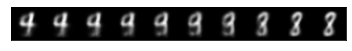

In [ ]:
interpolate_vae(vae,z_1,z_2)

In [ ]:
def interpolate_gan(autoencoder, z_1,z_2,n=10):
    z_1 =  Variable(z_1.cuda())
    z_2 =  Variable(z_2.cuda())
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder(z).view(10,1,32,32)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 32
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(32, 32)
    plt.imshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('./minist_gan_inte',dpi=400,bbox_inches='tight')

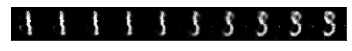

In [ ]:
interpolate_gan(G, z_1,z_2,n=10)

IMAGE NET

In [ ]:
import tarfile
fname = "/content/drive/MyDrive/imagenette2-160.tgz"
tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

In [ ]:

import torchvision.datasets as sets


class VAE_imgnet(nn.Module):
    def __init__(self,z_dim = 100):
        super(VAE_imgnet, self).__init__()
        self.z_dim =z_dim
        self._initialize_weights()
        self.encoder = nn.Sequential(
              nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),
              nn.BatchNorm2d(16),
              nn.LeakyReLU(0.2, inplace=True),
              
              nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
              nn.BatchNorm2d(32),
              nn.LeakyReLU(0.2, inplace=True),
                  
              nn.Conv2d(32, 32, kernel_size=4 ,stride=2, padding=1),
              nn.BatchNorm2d(32),
              nn.LeakyReLU(0.2, inplace=True), 

              nn.Conv2d(32, 64, kernel_size=4 ,stride=2, padding=1),
              nn.BatchNorm2d(64),
              nn.LeakyReLU(0.2, inplace=True), 

              nn.Conv2d(64, 100, kernel_size=10 ,stride=1, padding=0),
              nn.Tanh()                
              )
        
        self.decoder = nn.Sequential(             
              nn.ConvTranspose2d(100, 64, kernel_size=10, stride=1, padding=0),
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True),
              
              nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
              nn.BatchNorm2d(32),
              nn.ReLU(inplace=True),

              nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
              nn.BatchNorm2d(32),
              nn.ReLU(inplace=True),

              nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
              nn.BatchNorm2d(16),
              nn.ReLU(inplace=True),

              nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
              nn.Sigmoid()
              )

    def reparameterize(self, mu, logvar):
        eps = Variable(torch.randn(mu.size(0), mu.size(1))).to(device)
        z = mu + eps * torch.exp(logvar/2)            
        
        return z
    
    def forward(self, x):
        out1, out2 = self.encoder(x), self.encoder(x)  # batch_s, 8, 7, 7
        mu = out1.view(out1.size(0),self.z_dim)    # batch_s, latent
        logvar = out2.view(out1.size(0),self.z_dim) # batch_s, latent
        z = self.reparameterize(mu, logvar)
        z = z.view(z.size(0), self.z_dim, 1, 1)    # batch_s, latent      
        out3 = self.decoder(z)   # batch_s, 8, 7, 7
        
        return out3, mu, logvar
    
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def loss_func(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x,reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE+KLD

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = loss_func(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return train_loss / len(train_loader.dataset)

def test():
    vae.eval()
    test_loss= 0
    FID = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)
            recon, mu, log_var = vae(data)
            test_loss += loss_func(recon, data, mu, log_var).item()
        for batch_idx, (data, _) in enumerate(test_loader):
            if batch_idx <=5:
                data = data.to(device)
                true = data
                false,_,_ = vae.forward(data)
                FID += calculate_fretchet(true,false)

        
    test_loss /= len(test_loader.dataset)
    FID /= 5
    print('====> Test set loss: {:.4f}'.format(test_loss))
    print('====> FID: {:.4f}'.format(FID))

    return test_loss,FID

def run(Epoch):
    train_loss = []
    test_loss = []
    FID_list = []
    for epoch in range(Epoch):
        train_l = train(epoch)
        test_l,FID = test()
        train_loss.append(train_l)
        test_loss.append(test_l)
        FID_list.append(FID)
    return train_loss,test_loss,FID_list



# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.Resize(160),
    transforms.RandomResizedCrop(size=(160,160)),
    transforms.ToTensor(),
    ###change mean
    # transforms.Normalize(mean = [ 0, 0, 0 ],
    #                       std  = [ 1, 1, 1 ]),
    ])
trainset = sets.ImageFolder('./imagenette2-160/train', transform)

testset = sets.ImageFolder('./imagenette2-160/val', transform)

# trainset = sets.ImageFolder('/content/imagenette2-160/train', transform)

# testset = sets.ImageFolder('/content/imagenette2-160/val', transform)


train_subset, val_subset = torch.utils.data.random_split(
        trainset, [8000, 1469], generator=torch.Generator().manual_seed(1))

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=50, shuffle=True,drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=50, shuffle=True,drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=50, shuffle=False,drop_last=True)

vae = VAE_imgnet().to(device)
optimizer =  optim.Adam(vae.parameters(), lr=0.0001)
train_loss_img,test_loss_img,FID_list_img = run(80)

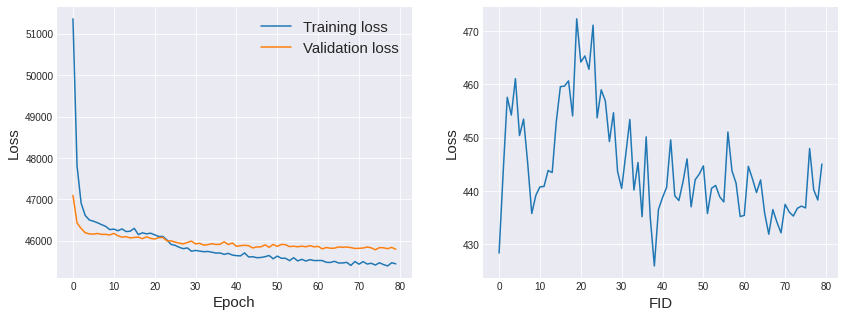

In [ ]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(train_loss_img,label='Training loss')
plt.plot(test_loss_img+30000,label = 'Validation loss')
plt.xlabel('Epoch',size=15)
plt.ylabel('Loss',size=15)
plt.legend(fontsize=15)
plt.subplot(122)
plt.plot(FID_list_img)
plt.xlabel('FID',size=15)
plt.ylabel('Loss',size=15)
plt.savefig('./img_vae1',dpi=400,bbox_inches='tight')

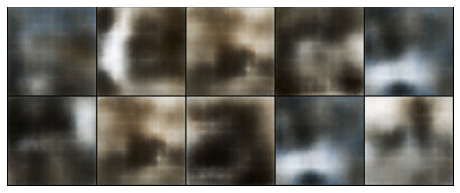

In [ ]:
fixed_noise = torch.randn(10, 100, 1, 1, device=device)
fake_display = vae.decoder(fixed_noise).detach().cpu()
plt.figure(figsize=(8,8))
plt.axis("off")
pictures=torchvision.utils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
plt.imshow(np.transpose(pictures,(1,2,0)))
plt.savefig('./random_sample_vae',dpi=400,bbox_inches='tight')
plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self._initialize_weights()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, 64, 10, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(32, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( 32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )


    def forward(self, input):
        return self.main(input)

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

class Discriminator(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self._initialize_weights()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(32, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(64, 1, 10, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



def D_train(x,batch_size=50, z_dim=100, image_dim=3,train =True):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x, torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real).view(batch_size,1)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(batch_size, z_dim,1,1).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake).view(batch_size,1)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss

    if train == True:
        D_loss.backward()
        D_optimizer.step()

    return  D_loss.data.item()

def G_train(x, batch_size=50, z_dim=100,train =True):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim,1,1).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output).view(batch_size,1)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    if train == True:
        G_loss.backward()
        G_optimizer.step()

    return G_loss.data.item()


def test(batch_size=50,z_dim=100):
    G.eval()
    D.eval()
    test_D = 0
    test_G = 0
    FID = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            test_D += D_train(data,batch_size=batch_size,z_dim=z_dim,train=False)
            test_G += G_train(data,batch_size=batch_size,z_dim=z_dim,train=False)

        for batch_idx, (data, _) in enumerate(test_loader):
            if batch_idx <=3:
                true = data.to(device)
                z =  Variable(torch.randn(batch_size, z_dim,1,1).to(device))
                fake = G(z)
                FID += calculate_fretchet(true,fake)

    test_G /= len(val_loader.dataset)
    test_D /= len(val_loader.dataset)
    FID /= 3
    print('====> Test set loss D, G : ', test_D,test_G)
    print('====> FID: ',FID)

    return test_G,test_D,FID

def run(Epoch=10,batch_size=50,z_dim=100):
    D_losses, G_losses, FID_class = [], [],[]
    testD_loss, testG_loss,FID_l = [],[],[]
    for epoch in range(Epoch): 
        train_D,train_G = 0,0          
        for batch_idx, (x, _) in enumerate(train_loader):
            train_D += D_train(x,batch_size=batch_size,z_dim=z_dim)
            train_G += G_train(x,batch_size=batch_size,z_dim=z_dim)
        
        test_G,test_D,FID = test()
        D_losses.append(train_D/len(train_loader.dataset))
        G_losses.append(train_G/len(train_loader.dataset))
        testG_loss.append(test_G)
        testD_loss.append(test_D)
        FID_l.append(FID)
        

        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f, FID:%.3f' % (
                (epoch+1), Epoch, train_D/len(train_loader.dataset), train_G/len(train_loader.dataset),FID))
    return D_losses,G_losses,testG_loss,testD_loss,FID_l


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator().to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss(reduction='sum') 
# optimizer
lr = 0.00005
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

# MNIST Dataset

# MNIST Dataset
transform = transforms.Compose([
    transforms.Resize(160),
    transforms.RandomResizedCrop(size=(160,160)),
    transforms.ToTensor(),
    ###change mean
    # transforms.Normalize(mean = [ 0, 0, 0 ],
    #                       std  = [ 1, 1, 1 ]),
    ])
trainset = sets.ImageFolder('/content/imagenette2-160/train', transform)

testset = sets.ImageFolder('/content/imagenette2-160/val', transform)

# trainset = sets.ImageFolder('./imagenette2-160/train', transform)

# testset = sets.ImageFolder('./imagenette2-160/val', transform)


train_subset, val_subset = torch.utils.data.random_split(
        trainset, [8000, 1469], generator=torch.Generator().manual_seed(1))

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=50, shuffle=True,drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=50, shuffle=True,drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=50, shuffle=False,drop_last=True)

D_losses_img,G_losses_img,testG_loss_img,testD_loss_img,FID_l_img = run(Epoch=150)


In [ ]:
D_losses_img = np.load('/content/D_losses_img.npy')
G_losses_img = np.load('/content/G_losses_img.npy')
testG_loss_img = np.load('/content/testG_loss_img.npy')
testD_loss_img = np.load('/content/testD_loss_img.npy')
FID_l_img = np.load('/content/FID_l_img.npy')

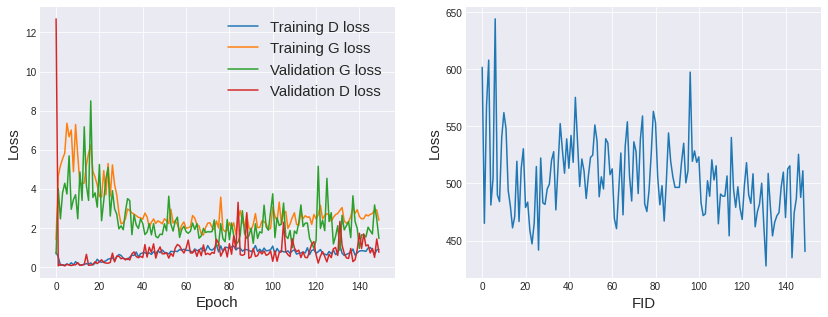

In [ ]:
# D_losses,G_losses,testG_loss,testD_loss,FID_l

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(D_losses_img,label='Training D loss')
plt.plot(G_losses_img,label = 'Training G loss')
plt.plot(testG_loss_img,label='Validation G loss')
plt.plot(testD_loss_img,label = 'Validation D loss')
plt.xlabel('Epoch',size=15)
plt.ylabel('Loss',size=15)
plt.legend(fontsize=15)
plt.subplot(122)
plt.plot(FID_l_img)
plt.xlabel('FID',size=15)
plt.ylabel('Loss',size=15)
plt.savefig('./img_gan',dpi=400,bbox_inches='tight')

In [ ]:
G = torch.load('/content/G')

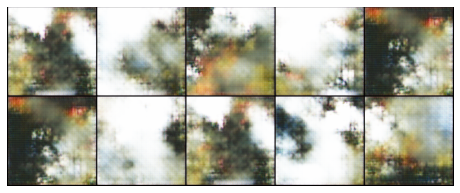

In [ ]:
fixed_noise = torch.randn(16, 100, 1, 1, device=device)
fake_display = G(fixed_noise).detach().cpu()
plt.figure(figsize=(8,8))
plt.axis("off")
pictures=torchvision.utils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
plt.imshow(np.transpose(pictures,(1,2,0)))
plt.savefig('./random_sample_gan',dpi=400,bbox_inches='tight')
plt.show()

In [ ]:
z_1 = torch.randn(1, 100,1,1)
z_2 = torch.randn(1, 100,1,1)

In [ ]:
def interpolate_vae(autoencoder,z_1,z_2, n=10):
    z_1 =  Variable(z_1.cuda())
    z_2 =  Variable(z_2.cuda())
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    z = z.view(10,100,1,1)
    interpolate_list = vae.decoder(z)
    fake_display = interpolate_list.to('cpu').detach()

    plt.figure(figsize=(8,8))
    plt.axis("off")
    pictures=torchvision.utils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
    plt.imshow(np.transpose(pictures,(1,2,0)))
    plt.savefig('./intee_vae',dpi=400,bbox_inches='tight')
    plt.show()

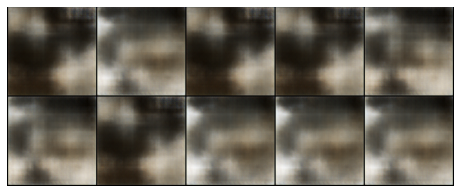

In [ ]:
interpolate_vae(vae, z_1,z_2,n=10)

In [ ]:
def interpolate_gan(autoencoder, z_1,z_2,n=10):
    z_1 =  Variable(z_1.cuda())
    z_2 =  Variable(z_2.cuda())
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    z = z.view(10,100,1,1)
    interpolate_list = autoencoder(z)
    fake_display = interpolate_list.to('cpu').detach()

    plt.figure(figsize=(8,8))
    plt.axis("off")
    pictures=torchvision.utils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
    plt.imshow(np.transpose(pictures,(1,2,0)))
    plt.savefig('./intee_gan',dpi=400,bbox_inches='tight')
    plt.show()
    # plt.savefig('./minist_gan_inte',dpi=400,bbox_inches='tight')

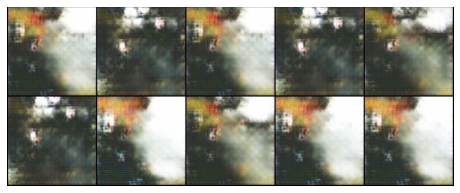

In [ ]:
interpolate_gan(G, z_1,z_2,n=10)

Improved GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

import random
img_list = []
G_losses = []
D_losses = []
iters = 0
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

SEED=42
random.seed(SEED)
torch.manual_seed(SEED)
# Batch size during training
batch_size = 50
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 70
# different Learning rate for optimizers
g_lr = 0.0001
d_lr = 0.0004
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
ngpu=1
# Initialize BCELoss function
criterion = nn.BCELoss()
# Establish convention for real and fake labels during training
# real_label = 1
# fake_label = 0
"""adding label smoothing"""
real_label=0.9
fake_label=0.1
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(ngpu).to(device)
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
# Print the model
print(netD)
# Setup Adam optimizers for both G and D

optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(beta1, 0.999))




Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:


#normalizing input between -1 and 1
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(64),
      transforms.RandomResizedCrop(size=(64,64)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        # download=True, transform=transform)

dataset = sets.ImageFolder('/content/imagenette2-160/train', transform)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Starting Training Loop...
[5/70]	Loss_D: 0.7985	Loss_G: 1.3461	Fretchet_Distance: 318.5490


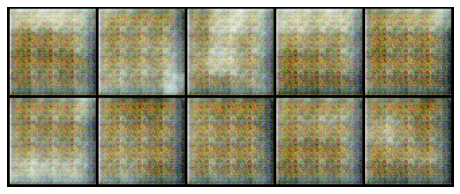

[10/70]	Loss_D: 0.9047	Loss_G: 1.5897	Fretchet_Distance: 373.6485


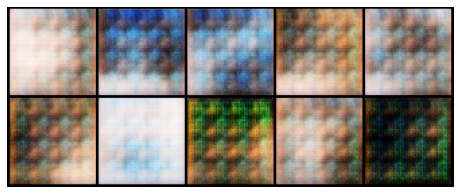

[15/70]	Loss_D: 1.1455	Loss_G: 2.4963	Fretchet_Distance: 333.4954


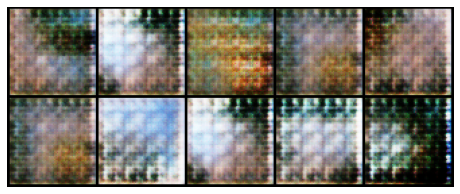

[20/70]	Loss_D: 0.9130	Loss_G: 1.2423	Fretchet_Distance: 289.6111


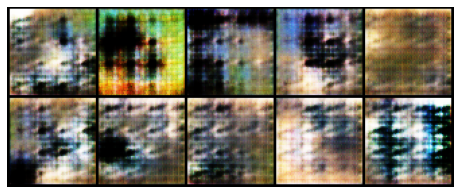

[25/70]	Loss_D: 0.8114	Loss_G: 3.0940	Fretchet_Distance: 293.5669


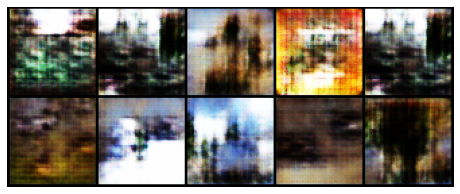

[30/70]	Loss_D: 0.7874	Loss_G: 2.4143	Fretchet_Distance: 315.7115


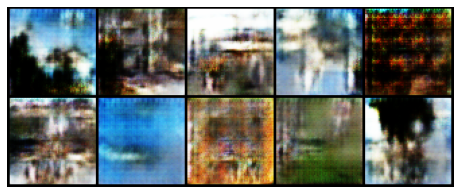

[35/70]	Loss_D: 0.8539	Loss_G: 2.0084	Fretchet_Distance: 300.9187


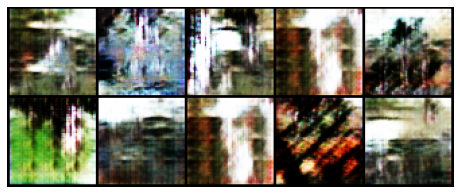

[40/70]	Loss_D: 0.8004	Loss_G: 2.5781	Fretchet_Distance: 265.8173


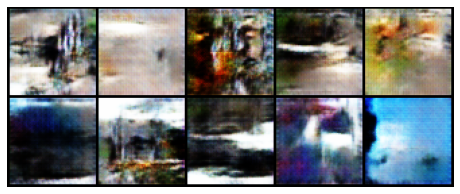

[45/70]	Loss_D: 0.9590	Loss_G: 3.8400	Fretchet_Distance: 289.1315


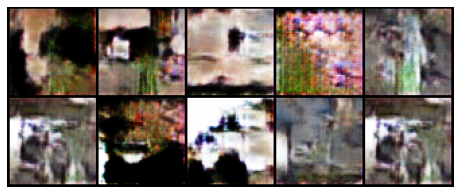

[50/70]	Loss_D: 0.7662	Loss_G: 1.8371	Fretchet_Distance: 238.4776


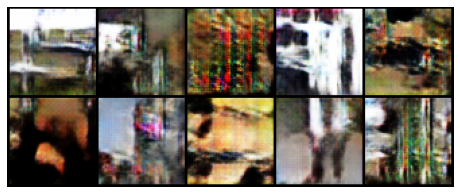

[55/70]	Loss_D: 0.7574	Loss_G: 2.1150	Fretchet_Distance: 291.7910


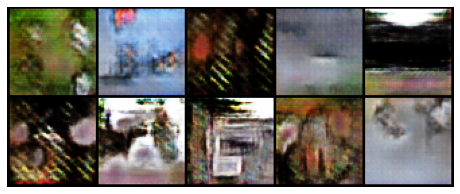

[60/70]	Loss_D: 0.7553	Loss_G: 2.6807	Fretchet_Distance: 274.7262


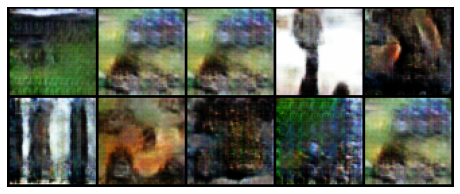

[65/70]	Loss_D: 1.0279	Loss_G: 3.1891	Fretchet_Distance: 282.5691


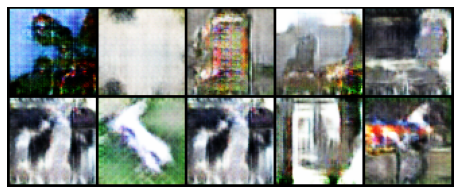

[70/70]	Loss_D: 0.7383	Loss_G: 3.4155	Fretchet_Distance: 282.3442


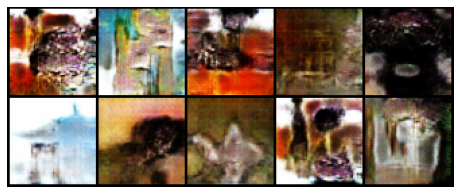

In [ ]:
import torchvision
img_list = []
G_losses = []
D_losses = []
fidlist=[]
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
#         # add some noise to the input to discriminator
        
        real_cpu=0.9*real_cpu+0.1*torch.randn((real_cpu.size()), device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        
        fake=0.9*fake+0.1*torch.randn((fake.size()), device=device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()
        
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fixed_noise = torch.randn(ngf, nz, 1, 1, device=device)
                fake_display = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake_display, padding=2, normalize=True))
            
        iters += 1   
    G_losses.append(errG.item())
    D_losses.append(errD.item())     
    fretchet_dist=calculate_fretchet(real_cpu,fake,model) 
    fidlist.append(fretchet_dist)
    if ((epoch+1)%5==0):
        
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tFretchet_Distance: %.4f'
                      % (epoch+1, num_epochs,
                         errD.item(), errG.item(),fretchet_dist))
        
        
        plt.figure(figsize=(8,8))
        plt.axis("off")
        pictures=torchvision.utils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
        plt.imshow(np.transpose(pictures,(1,2,0)))
        plt.show()

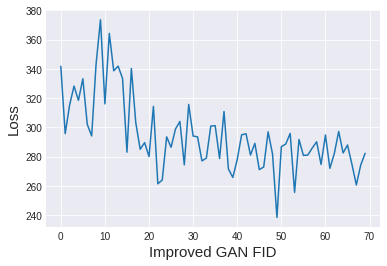

In [ ]:
plt.plot(fidlist)
plt.xlabel('Improved GAN FID',size=15)
plt.ylabel('Loss',size=15)
plt.savefig('./improve_gan_FID',dpi=400,bbox_inches='tight')

In [ ]:
torch.save(netD,'./netD')
torch.save(netG,'./netG')

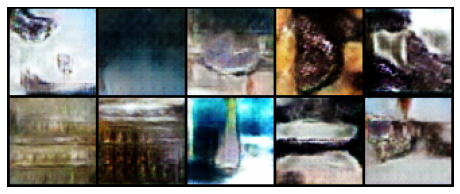

In [ ]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
fake_display = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(8,8))
plt.axis("off")
pictures=torchvision.utils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
plt.imshow(np.transpose(pictures,(1,2,0)))
plt.savefig('./improve_gan_inte',dpi=400,bbox_inches='tight')
plt.show()

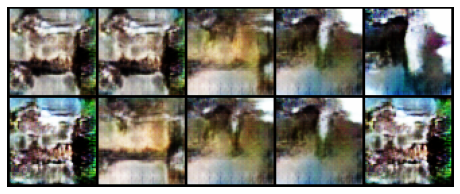

In [ ]:
interpolate_gan(netG, z_1,z_2,n=10)